In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class FootUlcerDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        image_dir: path to images (jpg)
        mask_dir:  path to masks  (png)
        transform: albumentations or similar transform pipeline
        """
        self.image_dir = image_dir
        self.mask_dir  = mask_dir
        self.transform = transform
        
        # Verify directories exist
        if not os.path.exists(image_dir):
            raise RuntimeError(f"Image directory not found: {image_dir}")
        if not os.path.exists(mask_dir):
            raise RuntimeError(f"Mask directory not found: {mask_dir}")
        
        # Collect list of image filenames and verify corresponding masks exist
        self.image_names = []
        for f in sorted(os.listdir(image_dir)):
            if f.endswith('.jpg'):
                base_name = os.path.splitext(f)[0]
                mask_name = base_name + ".png"
                mask_path = os.path.join(mask_dir, mask_name)
                if os.path.exists(mask_path):
                    self.image_names.append(f)
                else:
                    print(f"Warning: No matching mask found for {f}")
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        try:
            img_name = self.image_names[idx]
            img_path = os.path.join(self.image_dir, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if image is None:
                raise RuntimeError(f"Failed to load image: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load mask
            base_name = os.path.splitext(img_name)[0]
            mask_name = base_name + ".png"
            mask_path = os.path.join(self.mask_dir, mask_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise RuntimeError(f"Failed to load mask: {mask_path}")
            
            # Ensure mask is binary 0/1
            mask = (mask > 127).astype(np.int64)  # Explicitly use int64
            
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented["image"]
                mask = augmented["mask"].long()
            else:
                image = torch.from_numpy(image.transpose(2,0,1)).float()
                mask = torch.from_numpy(mask).long()
            
            return image, mask
            
        except Exception as e:
            print(f"Error loading data at index {idx}: {str(e)}")
            raise

# Create transforms
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# Paths (update as needed)
train_image_dir = r"C:\Users\Shijie Wang\Desktop\Research\DUCSS\DFUC2022\DFUC2022_train_release\DFUC2022_train_images\train"
train_mask_dir  = r"C:\Users\Shijie Wang\Desktop\Research\DUCSS\DFUC2022\DFUC2022_train_release\DFUC2022_train_masks\train"

val_image_dir   = r"C:\Users\Shijie Wang\Desktop\Research\DUCSS\DFUC2022\DFUC2022_train_release\DFUC2022_train_images\val"
val_mask_dir    = r"C:\Users\Shijie Wang\Desktop\Research\DUCSS\DFUC2022\DFUC2022_train_release\DFUC2022_train_masks\val"

# Create dataset instances
train_dataset = FootUlcerDataset(train_image_dir, train_mask_dir, transform=train_transform)
val_dataset   = FootUlcerDataset(val_image_dir,   val_mask_dir,   transform=val_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=4,
    shuffle=True, 
    num_workers=0,  # Set to 0 to disable multiprocessing
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,   
    batch_size=4,
    shuffle=False, 
    num_workers=0,  # Set to 0 to disable multiprocessing
    pin_memory=False
)

test_batch = next(iter(train_loader))
images, masks = test_batch

print(f"Image batch shape: {images.shape}")
print(f"Mask batch shape: {masks.shape}")
print(f"Image dtype: {images.dtype}")
print(f"Mask dtype: {masks.dtype}")
print(f"Unique values in masks: {torch.unique(masks)}")
print(f"Min/Max values in images: {images.min():.2f}/{images.max():.2f}")


Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 256, 256])
Image dtype: torch.float32
Mask dtype: torch.int64
Unique values in masks: tensor([0, 1])
Min/Max values in images: -2.12/2.64


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=2):
        super(UNet, self).__init__()
        # We assume n_classes = 2 (background & ulcer). 
        # If you want a single-channel output with 0/1 predictions, 
        # you'd set n_classes=1 and adapt the loss function accordingly.

        self.dc1 = DoubleConv(3, 64)
        self.dc2 = DoubleConv(64, 128)
        self.dc3 = DoubleConv(128, 256)
        self.dc4 = DoubleConv(256, 512)
        self.dc5 = DoubleConv(512, 1024)
        
        self.pool = nn.MaxPool2d(2)
        
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.uc4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.uc3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.uc2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.uc1 = DoubleConv(128, 64)
        
        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoding
        c1 = self.dc1(x)
        p1 = self.pool(c1)
        
        c2 = self.dc2(p1)
        p2 = self.pool(c2)
        
        c3 = self.dc3(p2)
        p3 = self.pool(c3)
        
        c4 = self.dc4(p3)
        p4 = self.pool(c4)
        
        c5 = self.dc5(p4)
        
        # Decoding
        u4 = self.up4(c5)
        merge4 = torch.cat([u4, c4], dim=1)
        c6 = self.uc4(merge4)
        
        u3 = self.up3(c6)
        merge3 = torch.cat([u3, c3], dim=1)
        c7 = self.uc3(merge3)
        
        u2 = self.up2(c7)
        merge2 = torch.cat([u2, c2], dim=1)
        c8 = self.uc2(merge2)
        
        u1 = self.up1(c8)
        merge1 = torch.cat([u1, c1], dim=1)
        c9 = self.uc1(merge1)
        
        out = self.out_conv(c9)
        return out


In [4]:
import torch.optim as optim
import matplotlib.pyplot as plt

def calculate_metrics(pred, target):
    """Calculate accuracy, IoU and Dice coefficient"""
    pred = pred.argmax(dim=1)

    accuracy = (pred == target).float().mean().item()
    
    # IoU for positive class (ulcer)
    intersection = ((pred == 1) & (target == 1)).float().sum().item()
    union = ((pred == 1) | (target == 1)).float().sum().item()
    iou = intersection / (union + 1e-8)
    
    # Dice coefficient
    dice = (2 * intersection) / (((pred == 1).float().sum() + (target == 1).float().sum()) + 1e-8)
    
    return accuracy, iou, dice

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = UNet(n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10  # increase if you want better results

# Training history for plotting
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_iou': [], 'val_iou': [],
    'train_dice': [], 'val_dice': []
}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    running_iou = 0.0
    running_dice = 0.0
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print("Training:")
    
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.long().to(device)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, masks)
        
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        acc, iou, dice = calculate_metrics(logits.detach(), masks)
        
        # Update running metrics
        running_loss += loss.item() * images.size(0)
        running_acc += acc * images.size(0)
        running_iou += iou * images.size(0)
        running_dice += dice * images.size(0)
        
        if (i + 1) % 10 == 0:
            print(f"Batch [{i+1}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f}, "
                  f"Acc: {acc:.4f}, "
                  f"IoU: {iou:.4f}, "
                  f"Dice: {dice:.4f}")
    
    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_acc / len(train_loader.dataset)
    epoch_iou = running_iou / len(train_loader)
    epoch_dice = running_dice / len(train_loader)
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    val_running_iou = 0.0
    val_running_dice = 0.0
    
    print("\nValidation:")
    with torch.no_grad():
        for i, (val_images, val_masks) in enumerate(val_loader):
            val_images = val_images.to(device)
            val_masks = val_masks.long().to(device)
            
            val_logits = model(val_images)
            val_loss = criterion(val_logits, val_masks)
            
            # Calculate metrics
            val_acc, val_iou, val_dice = calculate_metrics(val_logits, val_masks)
            
            # Update running metrics
            val_running_loss += val_loss.item() * val_images.size(0)
            val_running_acc += val_acc * val_images.size(0)
            val_running_iou += val_iou * val_images.size(0)
            val_running_dice += val_dice * val_images.size(0)
    
    # Calculate validation epoch metrics
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_running_acc / len(val_loader.dataset)
    val_epoch_iou = val_running_iou / len(val_loader)
    val_epoch_dice = val_running_dice / len(val_loader)
    
    # Store metrics in history
    history['train_loss'].append(float(epoch_loss))
    history['val_loss'].append(float(val_epoch_loss))
    history['train_acc'].append(float(epoch_acc))
    history['val_acc'].append(float(val_epoch_acc))
    history['train_iou'].append(float(epoch_iou))
    history['val_iou'].append(float(val_epoch_iou))
    history['train_dice'].append(float(epoch_dice))
    history['val_dice'].append(float(val_epoch_dice))
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"Train - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, IoU: {epoch_iou:.4f}, Dice: {epoch_dice:.4f}")
    print(f"Val   - Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}, IoU: {val_epoch_iou:.4f}, Dice: {val_epoch_dice:.4f}")

# Save the model
torch.save(model.state_dict(), 'foot_ulcer_segmentation_model.pth')

Using device: cuda

Epoch [1/10]
Training:
Batch [10/400] Loss: 0.5011, Acc: 0.8855, IoU: 0.0064, Dice: 0.0127
Batch [20/400] Loss: 0.4172, Acc: 0.9083, IoU: 0.0294, Dice: 0.0571
Batch [30/400] Loss: 0.3408, Acc: 0.9680, IoU: 0.0143, Dice: 0.0283
Batch [40/400] Loss: 0.3282, Acc: 0.9515, IoU: 0.0100, Dice: 0.0197
Batch [50/400] Loss: 0.2833, Acc: 0.9596, IoU: 0.0874, Dice: 0.1608
Batch [60/400] Loss: 0.2450, Acc: 0.9852, IoU: 0.2929, Dice: 0.4531
Batch [70/400] Loss: 0.2994, Acc: 0.9212, IoU: 0.0062, Dice: 0.0122
Batch [80/400] Loss: 0.2235, Acc: 0.9758, IoU: 0.0000, Dice: 0.0000
Batch [90/400] Loss: 0.2113, Acc: 0.9769, IoU: 0.1184, Dice: 0.2117
Batch [100/400] Loss: 0.2349, Acc: 0.9635, IoU: 0.0000, Dice: 0.0000
Batch [110/400] Loss: 0.1808, Acc: 0.9959, IoU: 0.1011, Dice: 0.1836
Batch [120/400] Loss: 0.2726, Acc: 0.9294, IoU: 0.0012, Dice: 0.0024
Batch [130/400] Loss: 0.1745, Acc: 0.9874, IoU: 0.3311, Dice: 0.4975
Batch [140/400] Loss: 0.2337, Acc: 0.9561, IoU: 0.0087, Dice: 0.0172


Training History:


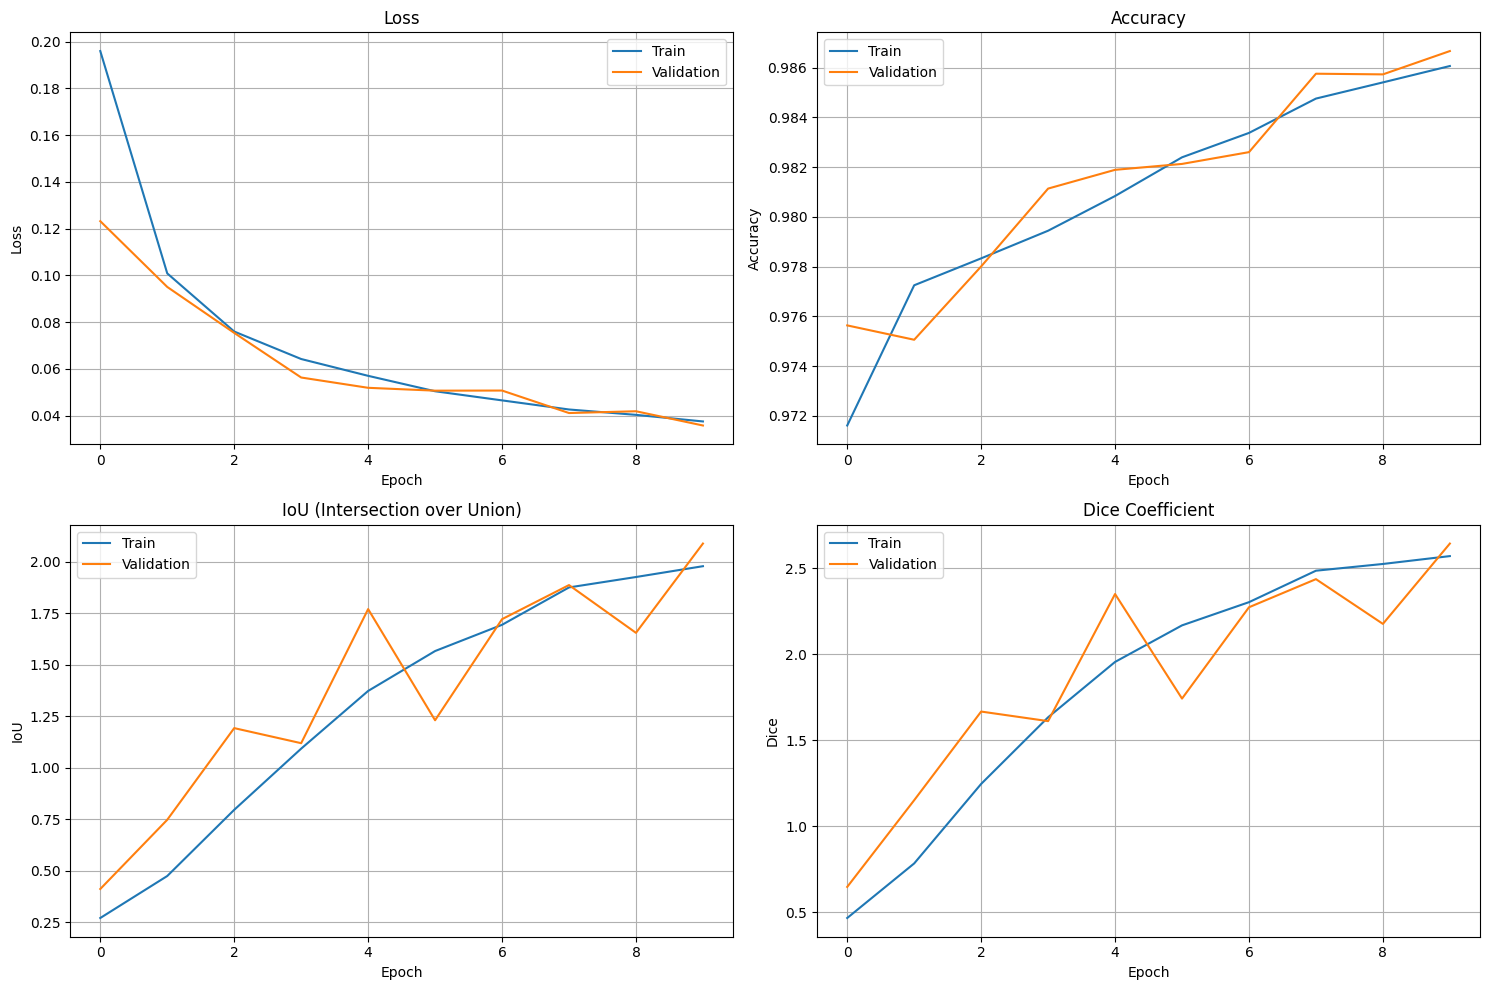


Sample Predictions:


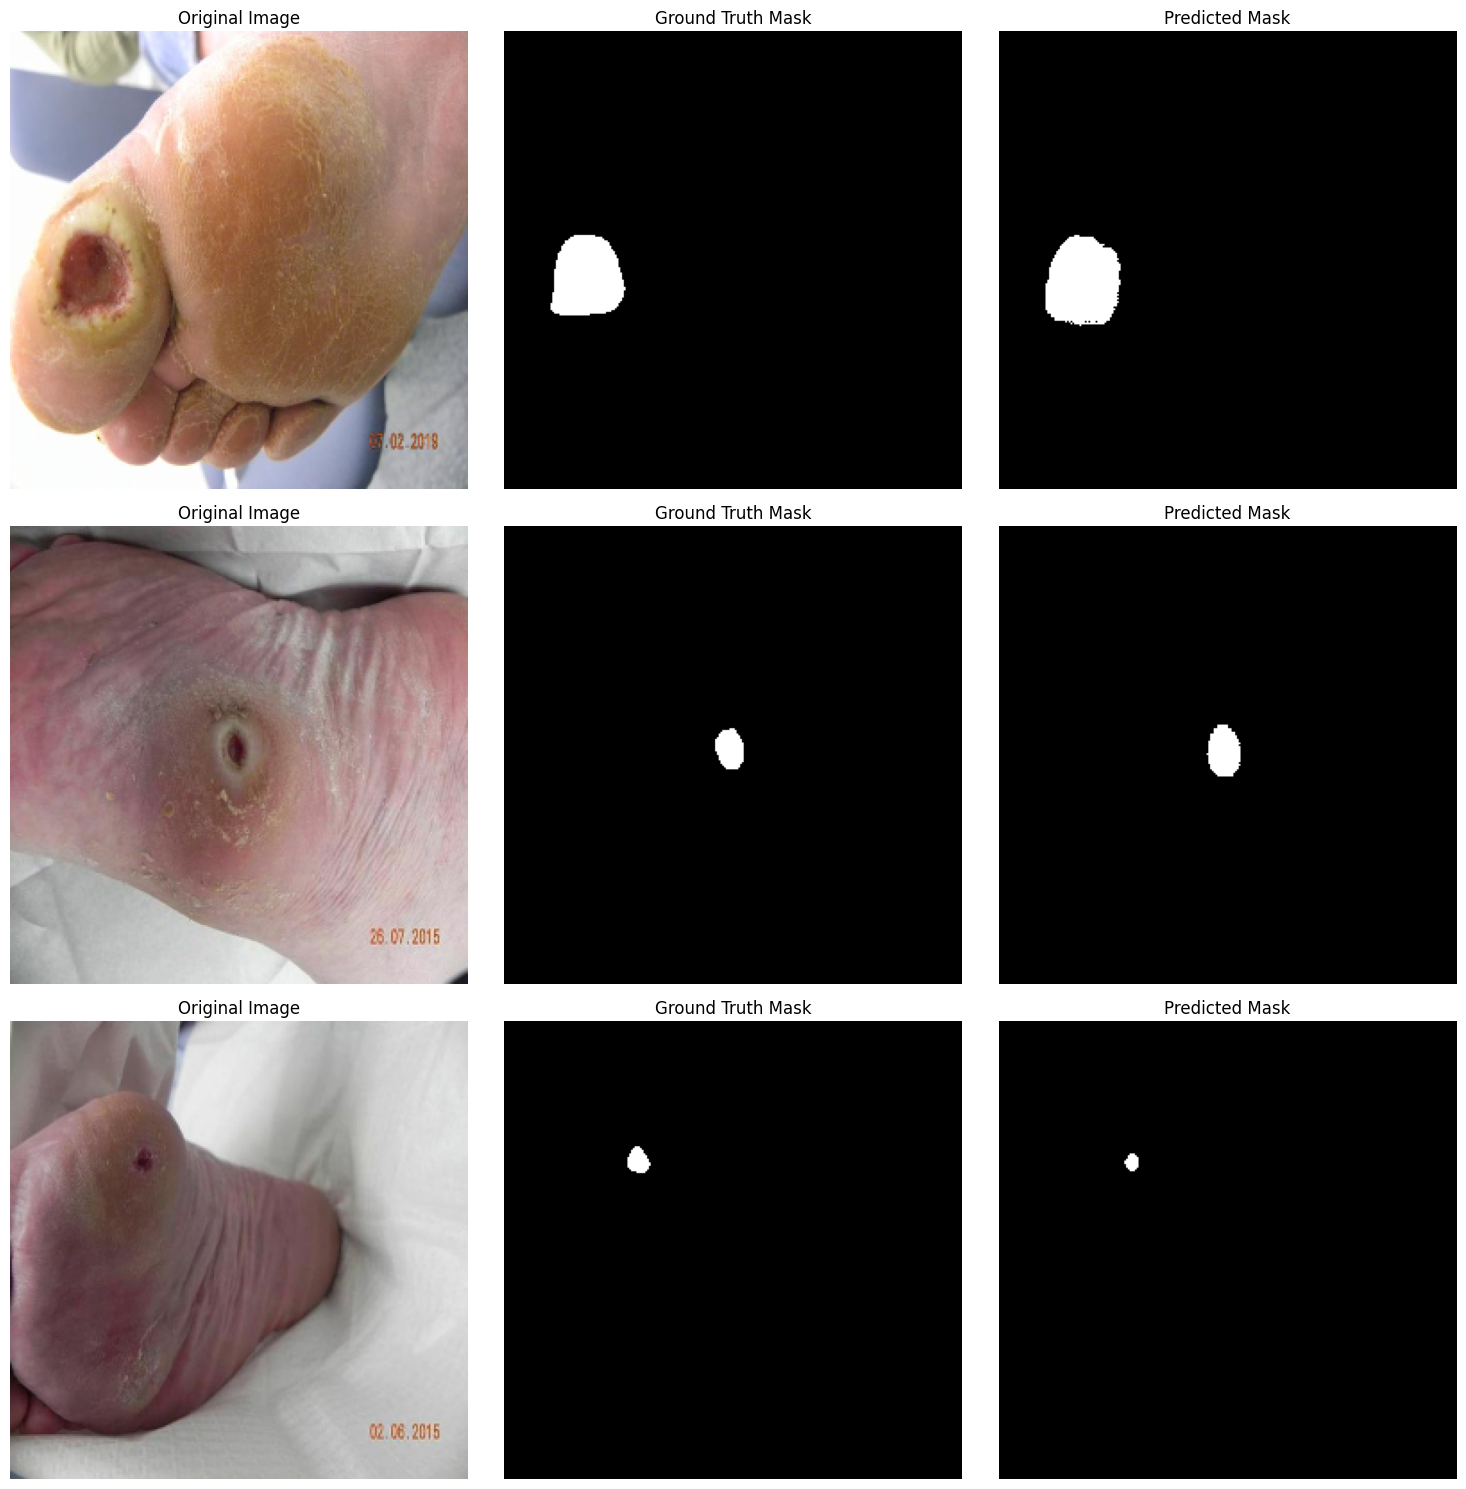


Metrics for Sample Predictions:

Sample 1 Metrics:
Accuracy: 0.9637
IoU: 0.2254
Dice: 0.3679

Sample 2 Metrics:
Accuracy: 0.9959
IoU: 0.8581
Dice: 0.9236

Sample 3 Metrics:
Accuracy: 0.9945
IoU: 0.8537
Dice: 0.9211

Final Results:
Best Training Metrics:
Loss: 0.0375
Accuracy: 0.9861
IoU: 1.9774
Dice: 2.5700

Best Validation Metrics:
Loss: 0.0358
Accuracy: 0.9867
IoU: 2.0873
Dice: 2.6429


In [5]:
# Plot training history
def plot_metrics(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0,0].plot(history['train_loss'], label='Train')
    axes[0,0].plot(history['val_loss'], label='Validation')
    axes[0,0].set_title('Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Accuracy
    axes[0,1].plot(history['train_acc'], label='Train')
    axes[0,1].plot(history['val_acc'], label='Validation')
    axes[0,1].set_title('Accuracy')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # IoU
    axes[1,0].plot(history['train_iou'], label='Train')
    axes[1,0].plot(history['val_iou'], label='Validation')
    axes[1,0].set_title('IoU (Intersection over Union)')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('IoU')
    axes[1,0].legend()
    axes[1,0].grid(True)
    
    # Dice
    axes[1,1].plot(history['train_dice'], label='Train')
    axes[1,1].plot(history['val_dice'], label='Validation')
    axes[1,1].set_title('Dice Coefficient')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Dice')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataloader, num_samples=3):
    """
    Visualize sample predictions from the model
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(dataloader):
            if idx >= num_samples:
                break
                
            # Get prediction
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            pred_masks = torch.argmax(outputs, dim=1)
            
            # Convert tensors to numpy arrays
            image = images[0].cpu().numpy().transpose(1,2,0)
            true_mask = masks[0].cpu().numpy()
            pred_mask = pred_masks[0].cpu().numpy()
            
            # Denormalize image
            image = (image * np.array([0.229, 0.224, 0.225]) + 
                    np.array([0.485, 0.456, 0.406]))
            image = np.clip(image, 0, 1)
            
            # Plot
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(true_mask, cmap='gray')
            axes[idx, 1].set_title('Ground Truth Mask')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(pred_mask, cmap='gray')
            axes[idx, 2].set_title('Predicted Mask')
            axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def print_sample_metrics(model, dataloader, num_samples=3):
    """
    Print metrics for sample predictions
    """
    model.eval()
    with torch.no_grad():
        for idx, (images, masks) in enumerate(dataloader):
            if idx >= num_samples:
                break
                
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            
            # Calculate metrics for this sample
            acc, iou, dice = calculate_metrics(outputs, masks)
            
            print(f"\nSample {idx+1} Metrics:")
            print(f"Accuracy: {acc:.4f}")
            print(f"IoU: {iou:.4f}")
            print(f"Dice: {dice:.4f}")

# Plot the metrics after training
print("Training History:")
plot_metrics(history)

# Visualize predictions
print("\nSample Predictions:")
visualize_predictions(model, val_loader, num_samples=3)

# Print metrics for the visualized samples
print("\nMetrics for Sample Predictions:")
print_sample_metrics(model, val_loader, num_samples=3)

# Print final metrics
print("\nFinal Results:")
print(f"Best Training Metrics:")
print(f"Loss: {min(history['train_loss']):.4f}")
print(f"Accuracy: {max(history['train_acc']):.4f}")
print(f"IoU: {max(history['train_iou']):.4f}")
print(f"Dice: {max(history['train_dice']):.4f}")

print(f"\nBest Validation Metrics:")
print(f"Loss: {min(history['val_loss']):.4f}")
print(f"Accuracy: {max(history['val_acc']):.4f}")
print(f"IoU: {max(history['val_iou']):.4f}")
print(f"Dice: {max(history['val_dice']):.4f}")